<a href="https://colab.research.google.com/github/Edriczz/OptimalControlbyGekko/blob/main/OptimalControlGekkoColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install gekko

In [26]:
# Sel 2: Impor Library
# Di sel ini, kita mengimpor semua library yang dibutuhkan:
# numpy untuk operasi numerik (terutama untuk array waktu).
# GEKKO dari library gekko untuk pemodelan dan optimasi.
# matplotlib.pyplot untuk membuat visualisasi hasil.

import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt

In [27]:
# Sel 3: Inisialisasi Model GEKKO dan Pengaturan Waktu
# Langkah pertama adalah membuat instance dari model GEKKO.
# 'remote=False' berarti perhitungan akan dilakukan secara lokal.
# Kemudian, kita mendefinisikan horizon waktu (tf) dan jumlah titik waktu (time_steps)
# untuk diskritisasi. m.time akan menjadi array dari t0 hingga tf.

m = GEKKO(remote=False) # Membuat objek model GEKKO

# Pengaturan waktu untuk simulasi dan optimasi
time_horizon = 60  # Durasi total waktu (misalnya, 10 unit waktu)
time_steps = 300   # Jumlah titik diskritisasi waktu (menghasilkan 100 interval)
m.time = np.linspace(0, time_horizon, time_steps) # Membuat array waktu dari 0 hingga time_horizon

# Menyimpan array waktu untuk kemudahan plotting nanti
t_plot = m.time


In [28]:
# Sel 4: Definisikan Parameter Model
# Parameter adalah konstanta dalam model yang nilainya sudah diketahui.
# Kita menggunakan m.Param() untuk mendefinisikannya di Gekko.

alpha = m.Param(value=0.0002, name='alpha')
beta = m.Param(value=0.04, name='beta')
# Berdasarkan dokumen, gamma1 digunakan, jadi kita sebut saja gamma
gamma = m.Param(value=0.03, name='gamma') # gamma1 dari dokumen
# gamma2 = m.Param(value=0.02) # Tidak digunakan dalam persamaan F, S, M yang dimodifikasi kontrol
mu = m.Param(value=0.15, name='mu')
eta = m.Param(value=0.03, name='eta')
theta = m.Param(value=0.03, name='theta')
Pi = m.Param(value=300, name='Pi_val') # Pi adalah konstanta di Python, jadi gunakan nama lain

# Parameter untuk biaya kontrol dalam fungsi objektif
C1 = m.Param(value=100, name='C1') # Bobot untuk kontrol u1
C2 = m.Param(value=100, name='C2') # Bobot untuk kontrol u2


In [29]:
# Sel 5: Definisikan Variabel State dan Kontrol
# Variabel state (E, F, S, M) adalah variabel yang berubah seiring waktu
# dan nilai awalnya diberikan. Kita menggunakan m.Var().
# Variabel kontrol (u1, u2) adalah variabel yang ingin kita optimalkan.
# Kita menggunakan m.MV (Manipulated Variable) untuk ini.
# lb dan ub adalah batasan bawah dan atas untuk kontrol.
# STATUS = 1 memberitahu Gekko untuk mengoptimalkan MV ini.

# Variabel State dengan nilai awal
E = m.Var(value=420, name='E', lb=0) # Jumlah mahasiswa baru
F = m.Var(value=1160, name='F', lb=0) # Jumlah mahasiswa kesulitan
S = m.Var(value=250, name='S', lb=0) # Jumlah mahasiswa menengah
M = m.Var(value=170, name='M', lb=0) # Jumlah mahasiswa unggul

# Variabel Kontrol (Manipulated Variables)
u1 = m.MV(value=0, lb=0, ub=1, name='u1') # Kontrol untuk F -> S
u1.STATUS = 1  # Aktifkan untuk optimasi oleh Gekko

u2 = m.MV(value=0, lb=0, ub=1, name='u2') # Kontrol untuk S -> M
u2.STATUS = 1  # Aktifkan untuk optimasi oleh Gekko


In [30]:
# Sel 6: Definisikan Persamaan Diferensial Model dan Fungsi Objektif

# Persamaan Diferensial Sistem (Model Terkontrol)
# E.dt() adalah turunan dE/dt
m.Equation(E.dt() == Pi - alpha * E * F - theta * E - eta * E - mu * E)
m.Equation(F.dt() == alpha * E * F - beta * F - mu * F - u1 * F)
m.Equation(S.dt() == theta * E + beta * F - gamma * S - mu * S + u1 * F - u2 * S)
m.Equation(M.dt() == gamma * S + eta * E - mu * M + u2 * S)

# Fungsi Objektif
# Tujuan: Minimalkan F(t) - M(t) (integral) + biaya kontrol (integral)
#         DAN minimalkan F(tf) - M(tf) (Mayer term / nilai akhir).

# Gekko secara otomatis mengintegralkan ekspresi yang diberikan ke m.Obj()
# Ini adalah bagian Lagrange dari fungsi objektif:
m.Obj(F - M + 0.5 * C1 * u1**2 + 0.5 * C2 * u2**2)

# Untuk Mayer term (nilai pada waktu akhir tf), kita perlu cara untuk
# mengisolasi nilai variabel pada titik waktu terakhir.
# Kita bisa membuat parameter 'final' yang bernilai 1 di akhir dan 0 di tempat lain.
final_marker = np.zeros(time_steps)
final_marker[-1] = 1.0  # Tandai titik waktu terakhir
final_param = m.Param(value=final_marker, name='final_marker')

# Tambahkan Mayer term ke fungsi objektif
m.Obj((F - M) * final_param)


In [31]:
# Sel 7: Konfigurasi Solver dan Jalankan Optimasi
# IMODE = 6 adalah mode untuk kontrol optimal (dynamic optimization).
# SOLVER = 3 memilih solver IPOPT, yang umumnya baik untuk masalah non-linear.
# NODES adalah jumlah titik kolokasi per interval waktu, mempengaruhi akurasi dan waktu komputasi.
# m.solve() menjalankan proses optimasi. disp=True menampilkan output dari solver.

m.options.IMODE = 6  # Mode kontrol optimal
m.options.SOLVER = 3 # Menggunakan solver IPOPT
m.options.NODES = 3  # Jumlah titik kolokasi (2-6 direkomendasikan)
m.options.MAX_ITER = 1000 # Opsional: Batas maksimum iterasi
m.options.RTOL = 1e-4 # Opsional: Toleransi relatif
m.options.OTOL = 1e-4 # Opsional: Toleransi optimalitas
m.solve(disp=True)   # Selesaikan masalah optimasi dan tampilkan log


 ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :           16
   Intermediates:            0
   Connections  :            0
   Equations    :            6
   Residuals    :            6
 
 Number of state variables:           8372
 Number of total equations: -         7774
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :            598
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Control with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0 -3.32090E+05  2.23359E-01
    1 -1.29411E+05  1.09229E+00
    2  1.94103E+

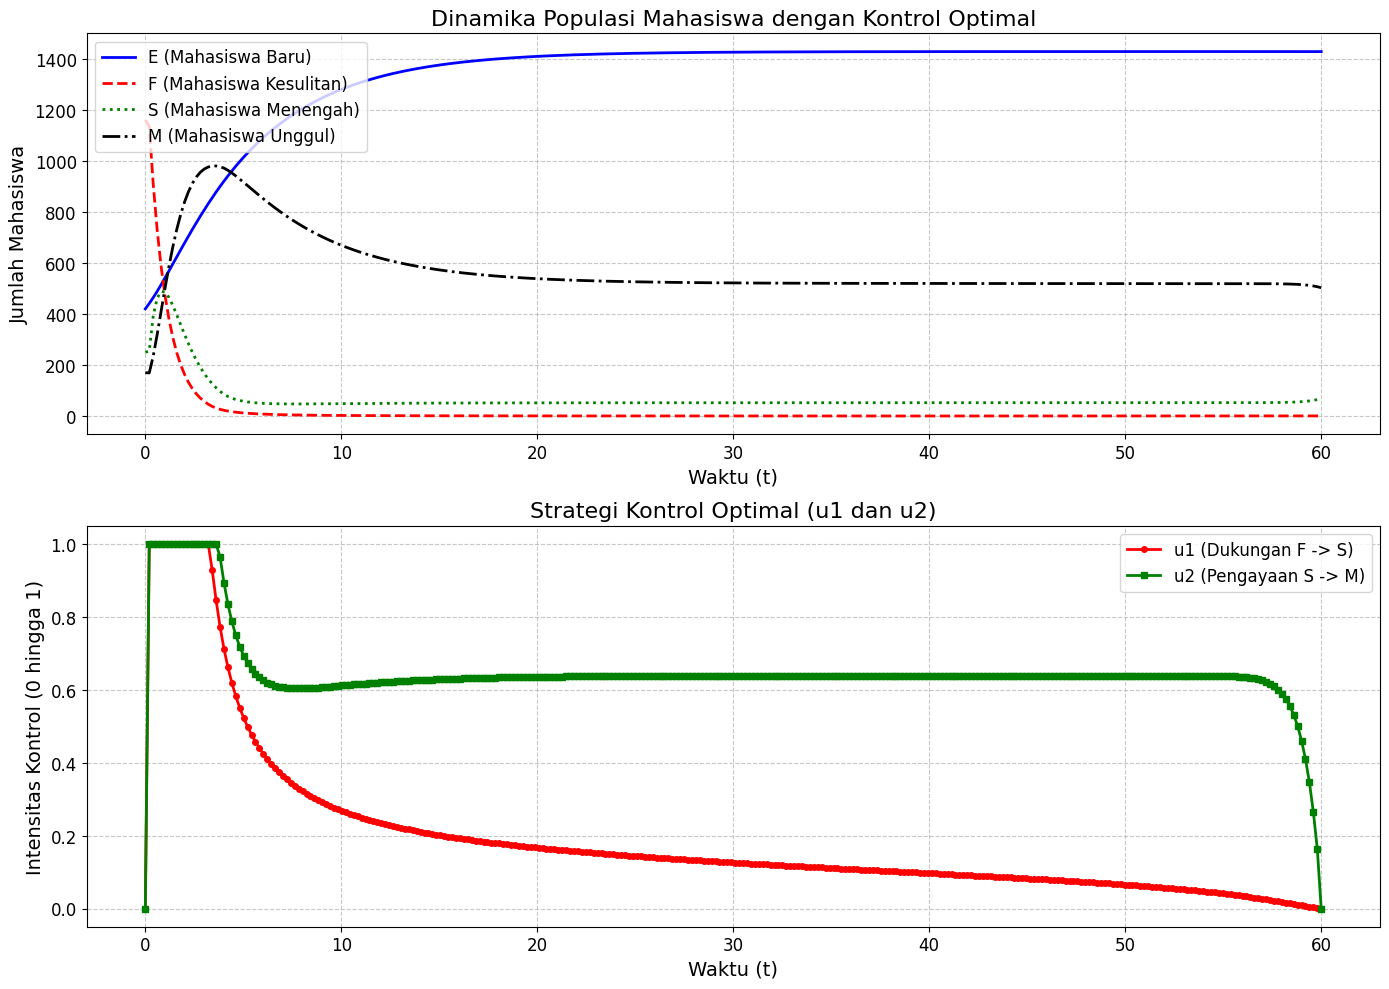

In [32]:
# Sel 8: Visualisasi Hasil Optimasi
# Setelah optimasi selesai, kita bisa memplot hasilnya untuk melihat
# bagaimana variabel state (E, F, S, M) dan variabel kontrol (u1, u2)
# berubah sepanjang waktu.

plt.figure(figsize=(14, 10)) # Mengatur ukuran figure agar lebih besar

# Plot untuk Variabel State (E, F, S, M)
plt.subplot(2, 1, 1) # Membuat subplot pertama (2 baris, 1 kolom, plot ke-1)
plt.plot(t_plot, E.value, 'b-', linewidth=2, label='E (Mahasiswa Baru)')
plt.plot(t_plot, F.value, 'r--', linewidth=2, label='F (Mahasiswa Kesulitan)')
plt.plot(t_plot, S.value, 'g:', linewidth=2, label='S (Mahasiswa Menengah)')
plt.plot(t_plot, M.value, 'k-.', linewidth=2, label='M (Mahasiswa Unggul)')
plt.title('Dinamika Populasi Mahasiswa dengan Kontrol Optimal', fontsize=16)
plt.xlabel('Waktu (t)', fontsize=14)
plt.ylabel('Jumlah Mahasiswa', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot untuk Variabel Kontrol (u1, u2)
plt.subplot(2, 1, 2) # Membuat subplot kedua (2 baris, 1 kolom, plot ke-2)
plt.plot(t_plot, u1.value, 'r-o', markersize=4, linewidth=2, label='u1 (Dukungan F -> S)')
plt.plot(t_plot, u2.value, 'g-s', markersize=4, linewidth=2, label='u2 (Pengayaan S -> M)')
plt.title('Strategi Kontrol Optimal (u1 dan u2)', fontsize=16)
plt.xlabel('Waktu (t)', fontsize=14)
plt.ylabel('Intensitas Kontrol (0 hingga 1)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim([-0.05, 1.05]) # Sedikit margin pada sumbu y untuk kontrol
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout() # Menyesuaikan layout agar tidak tumpang tindih
plt.show() # Menampilkan semua plot
